# Analyse

In [4]:
import ast
import json

In [53]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import sqlite3
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from pandas_profiling import ProfileReport

import statsmodels.formula.api as smf
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
import matplotlib.font_manager

In [6]:
#sklearn Befehle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

## Laden aus DWH

In [7]:
SQLITE_FILE_PATH = os.path.join('..', "output", "dwh.sqlite3")
PROFILE_PATH = os.path.join('..','output', 'movies_report.html')

In [8]:
SQLITE_FILE_PATH

'..\\output\\dwh.sqlite3'

In [9]:
connection = sqlite3.connect(SQLITE_FILE_PATH)

In [10]:
genres = pd.read_sql_query("SELECT * from genres;", connection)
genres

,genre_id,genre_name
0,16,Animation
1,35,Comedy
2,10751,Family
3,12,Adventure
4,14,Fantasy
5,10749,Romance
6,18,Drama
7,28,Action
8,80,Crime
9,53,Thriller


In [11]:
movies = pd.read_sql_query("SELECT * from movies;", connection)
movies.head()

,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count
0,False,30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,Released,None,Toy Story,0.0,7.7,5415.0
1,False,65000000,None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,0.0,6.9,2413.0
2,False,0,None,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,0.0,6.5,92.0
3,False,16000000,None,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,0.0,6.1,34.0
4,False,0,None,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,0.0,5.7,173.0


In [12]:
movies_genre = pd.read_sql_query("SELECT * from movies_genre;", connection)
movies_genre.head()

,movie_id,genre_id
0,862,16
1,862,35
2,862,10751
3,8844,12
4,8844,14


## Erster Überblick

In [13]:
profile = movies.profile_report(title="Pandas Profiling Report", minimal=True)
profile.to_file(PROFILE_PATH)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Spalten in SQL - Durchschnittliche Bewertung pro Genre

In [14]:
query = """
SELECT AVG(movies.vote_average) AS vote_avg, genres.genre_name FROM genres
JOIN movies_genre ON genres.genre_id = movies_genre.genre_id
JOIN movies ON movies.id = movies_genre.movie_id
GROUP BY genres.genre_name
ORDER BY vote_avg DESC
"""

avg_votes_df = pd.read_sql_query(query, con=connection)
avg_votes_df

,vote_avg,genre_name
0,6.274459,Animation
1,6.154220,History
2,6.041358,War
3,5.903890,Drama
4,5.879921,Crime
5,5.878500,Music
6,5.823222,Documentary
7,5.823071,Mystery
8,5.800815,Romance
9,5.781646,Fantasy


## Was nimmt ein Film ein
**Algorithmen:**<br>
    - statsmodels<br>
    - Regression in Scikit-learn<br>

**Zielvariable:**<br>
    - revenue<br>
    
**Input:**<br>
    - budget<br>
    - runtime<br>
    - votre_average<br>

### Blick in die Daten

In [18]:
movies["status"].unique()

array(['Released', None, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

In [62]:
df = movies[["original_title", "budget","status","revenue", "vote_average", "runtime", "original_language"]]
df.loc[df["status"] == "Released"]

,original_title,budget,status,revenue,vote_average,runtime,original_language
0,Toy Story,30000000,Released,373554033.0,7.7,81.0,en
1,Jumanji,65000000,Released,262797249.0,6.9,104.0,en
2,Grumpier Old Men,0,Released,0.0,6.5,101.0,en
3,Waiting to Exhale,16000000,Released,81452156.0,6.1,127.0,en
4,Father of the Bride Part II,0,Released,76578911.0,5.7,106.0,en
...,...,...,...,...,...,...,...
45458,رگ خواب,0,Released,0.0,4.0,90.0,fa
45459,Siglo ng Pagluluwal,0,Released,0.0,9.0,360.0,tl
45460,Betrayal,0,Released,0.0,3.8,90.0,en
45461,Satana likuyushchiy,0,Released,0.0,0.0,87.0,en


In [63]:
df.loc[df["runtime"] == 0 ]

,original_title,budget,status,revenue,vote_average,runtime,original_language
222,Dream Man,0,Released,0.0,2.5,0.0,en
224,Destiny Turns on the Radio,0,Released,0.0,5.3,0.0,it
398,Dos Crímenes,0,Released,0.0,5.0,0.0,en
554,"The Beans of Egypt, Maine",0,Released,0.0,0.0,0.0,en
667,The Run of the Country,0,Released,0.0,8.0,0.0,en
...,...,...,...,...,...,...,...
45367,Cómo funcionan casi todas las cosas,0,Released,0.0,6.8,0.0,es
45368,LEGO DC Super Hero Girls: Brain Drain,0,Released,0.0,10.0,0.0,en
45396,Все и сразу,750000,Released,3.0,6.0,0.0,ru
45413,Rigadin peintre cubiste,0,Released,0.0,0.0,0.0,en


**Macht es Sinn den Status als Variable zu benutzen, da ein nicht releater Film noch kein Einspielergebnis ("revenue") hat?**

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_title     45463 non-null  object 
 1   budget             45463 non-null  int64  
 2   status             45379 non-null  object 
 3   revenue            45460 non-null  float64
 4   vote_average       45460 non-null  float64
 5   runtime            45203 non-null  float64
 6   original_language  45452 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ MB


In [33]:
# wir löschen alle nicht auf dem Status released

In [65]:
df = movies[["original_title", "budget","revenue", "vote_average", "original_language"]].loc[movies["status"] == "Released"]
df.head()

,original_title,budget,revenue,vote_average,original_language
0,Toy Story,30000000,373554033.0,7.7,en
1,Jumanji,65000000,262797249.0,6.9,en
2,Grumpier Old Men,0,0.0,6.5,en
3,Waiting to Exhale,16000000,81452156.0,6.1,en
4,Father of the Bride Part II,0,76578911.0,5.7,en


### Statsmodels Vorhersage

<AxesSubplot:>

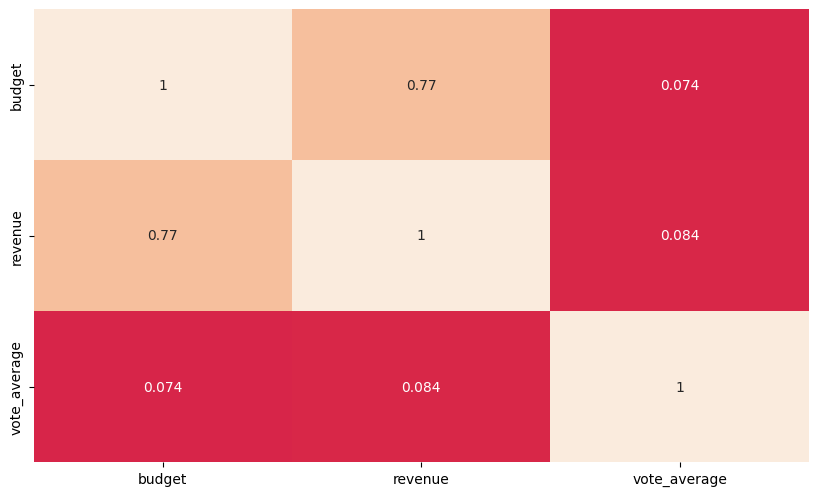

In [66]:
sns.heatmap(df.corr(),cbar=False, vmin=-1, vmax=1, cmap="rocket", annot=True)

In [49]:
# Revenue und budget korrellieren ziemlich stark

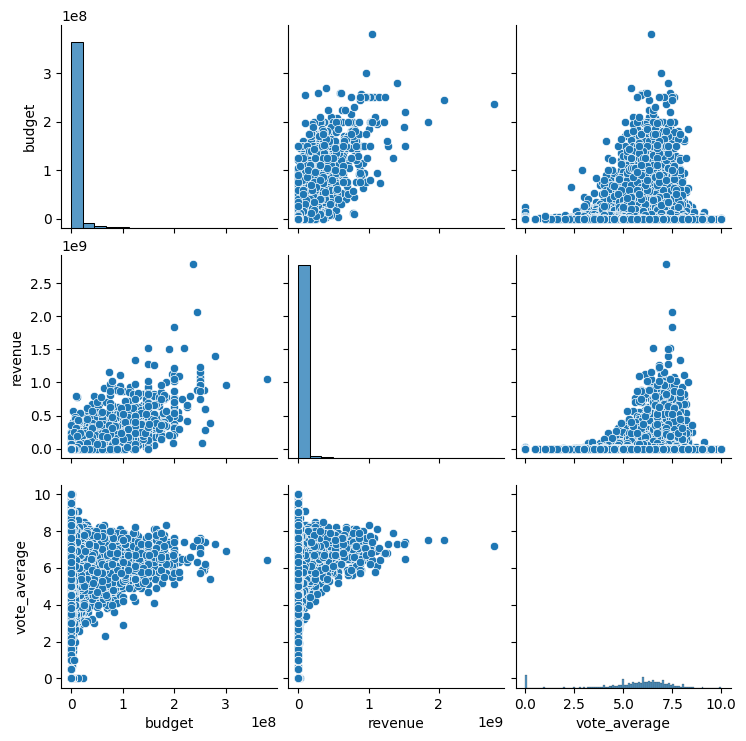

In [50]:
sns.pairplot(df)

In [58]:
# Revenue mit Budget vorhersagen
model = smf.ols(formula="revenue ~ budget", data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                 6.502e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:14:35   Log-Likelihood:            -8.5330e+05
No. Observations:               45014   AIC:                         1.707e+06
Df Residuals:                   45012   BIC:                         1.707e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.879e+05   2.01e+05     -3.928      0.0

In [97]:
# revenue mit 
model2 = smf.ols(formula="revenue ~ budget + vote_average", data=df)
results2 = model2.fit()
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                 3.261e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:31:38   Log-Likelihood:            -8.5326e+05
No. Observations:               45014   AIC:                         1.707e+06
Df Residuals:                   45011   BIC:                         1.707e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -6.013e+06   6.04e+05     -9.960   

In [166]:
text_file = open(os.path.join("..","media", "OLS_summary1.rst"),"w")
text_file.write(results2.summary().as_text())
text_file.close()

In [68]:
# revenue mit mit categorialer Variable der original Language zum Budget und vate_average
model2 = smf.ols(formula="revenue ~ budget + vote_average + C(original_language)", data=df)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     723.4
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:19:27   Log-Likelihood:            -8.5307e+05
No. Observations:               45004   AIC:                         1.706e+06
Df Residuals:                   44913   BIC:                         1.707e+06
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### scikit-learn Regression

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45014 entries, 0 to 45462
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_title     45014 non-null  object 
 1   budget             45014 non-null  int64  
 2   revenue            45014 non-null  float64
 3   vote_average       45014 non-null  float64
 4   original_language  45004 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ MB


In [70]:
num_cols = ["budget","vote_average"]
cat_cols = ["original_language"]
target = ["revenue"]

In [75]:
y= df["revenue"]
y.head()

0    373554033.0
1    262797249.0
2            0.0
3     81452156.0
4     76578911.0
Name: revenue, dtype: float64

In [71]:
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

In [72]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", OneHotEncoder(), cat_cols),
])

In [73]:
df1 = full_pipeline.fit_transform(df)
df1.shape

(45014, 92)

In [76]:
reg = LinearRegression().fit(df1,y )

In [77]:
reg.score(df1, y)

0.5917765635881711

## Revenue als Histogramm und exportieren

In [100]:
movies.head()

,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count
0,False,30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,Released,None,Toy Story,0.0,7.7,5415.0
1,False,65000000,None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,0.0,6.9,2413.0
2,False,0,None,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,0.0,6.5,92.0
3,False,16000000,None,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,0.0,6.1,34.0
4,False,0,None,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,0.0,5.7,173.0


In [110]:
movies.loc[movies["title"] == "Titanic"]

,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count
1639,False,200000000,http://www.titanicmovie.com,597,tt0120338,en,Titanic,"84 years later, a 101-year-old woman named Ros...",26.889070,/kHXEpyfl6zqn8a6YuozZUujufXf.jpg,1997-11-18,1.845034e+09,194.0,Released,Nothing on Earth could come between them.,Titanic,0.0,7.5,7770.0
3285,False,1805000,None,16535,tt0046435,en,Titanic,"Unhappily married, Julia Sturges decides to go...",12.907070,/8DMS4zPRF3uH4BZ8OC4GtZ8ewD9.jpg,1953-04-11,4.905000e+06,98.0,Released,TITANIC in Emotion...in Spectacle...in Climax....,Titanic,0.0,6.2,27.0
25472,False,13000000,None,2699,tt0115392,en,Titanic,A story of the romances of two couples upon th...,3.435807,/AosgVsKPbLctVQ8hd8shEj7LJrZ.jpg,1996-11-17,0.000000e+00,173.0,Released,None,Titanic,0.0,6.3,45.0


In [136]:
#Revenue vom richtigen Titanic von 1997 als Wert abspeichern

rev = movies.iloc[1639]['revenue']
rev

1845034188.0

In [138]:
histo = movies.loc[movies["revenue"]> 0]
histo.shape

(7408, 19)

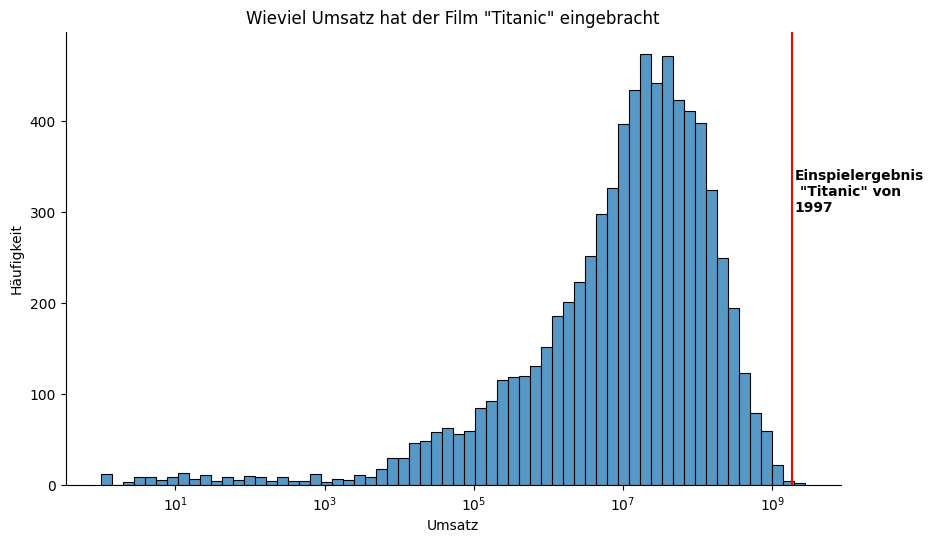

In [164]:
g = sns.histplot(data=histo, x="revenue", log_scale=True)
plt.axvline(rev, 0,1.0, color="red")
plt.text(rev+150000000, 300, "Einspielergebnis\n \"Titanic\" von \n1997", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.title("Wieviel Umsatz hat der Film \"Titanic\" eingebracht")
plt.xlabel("Umsatz")
plt.ylabel("Häufigkeit")

plt.savefig(os.path.join("..","media", "histo.png"))
plt.show()